# Identifying Persons of interest

In this project, I try to identify who can be considered persons of interest given information about Enron. In particular, we count with the following information_
- A number of emails disclosed by public authorities regarding the Enron case.
- A list that identifies person of interest (poi), i.e. employees that had a key role in Enron's scandal.
- Financial information about the employeess (e.g. bonuses, salary, exercised stock options).

We will use all the information available to feed it into a machine learning algorithm that would help us classify a person as person of interest or not. Machine learning is useful for this purpose given its capability of learning from the data to make predictions as accurate as possible. Also, by following the training/testing split process of work, we will have the possibility of assessing how accurate our predictions are. 

## Dataset background

As said before this dataset pieces together different information from the Enron case. To start with, different information is given for people associated with the ENRON scandal. The data has been collected from financial statements of the company and from the long list of emails that were disclosed as part of the ENRON trial. We provide a succint overview of the dataset, its shape and the variables thereof below.

In [565]:
import os
import re
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix, dmatrices
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from nltk.stem.snowball import SnowballStemmer
from tester import test_classifier
sys.path.append( "/Users/Jose/Documents/Udacity/data_science/intro_machine_learning/ud120-projects/tools" )
from parse_out_email_text import parseOutText

In [22]:
#Importing dataset intro a pandas dataframe and Transposing it
data_enron = pd.DataFrame(pd.read_pickle("final_project_dataset.pkl")).T

### Getting variables
As mentioned, the data set has in total 21 variables. From these, particularly important is `poi`. `poi` registers if a person is classified as a person of interest or not. This is the label that we will try to predict, given our features. 

In [23]:
#Columns
print data_enron.columns


Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')


### Getting observations
Interestingly, each observation that we get is atacched to a particular person. In total we have 146 observations. For matters of space, we only print the first 10.

In [24]:
data_enron.index[:10]

Index([u'ALLEN PHILLIP K', u'BADUM JAMES P', u'BANNANTINE JAMES M',
       u'BAXTER JOHN C', u'BAY FRANKLIN R', u'BAZELIDES PHILIP J',
       u'BECK SALLY W', u'BELDEN TIMOTHY N', u'BELFER ROBERT',
       u'BERBERIAN DAVID'],
      dtype='object')

In [25]:
# Passing appropriate NaN to dataset
data_enron = data_enron.replace(r"\bNaN\b", np.nan, regex = True)

## Identifying outliers

Outliers are observations that do not appear to correspond to typical values of our data. Outliers can be specially misleading in machine learning, where these points might exert a strong influence in our machine learning algorithm. Therefore, a solution to the outlier problem, once identified, is to take it out from the dataset.

In this case, well be looking at outliers using a linear regression. We will plot different regression of salaries on different variables and see how these regressions are affected by extreme values. To start with, our first plot warns us of a very important outlier that is quite a extreme value. it turns out this value corresponds to the "TOTAL" observation that accumulates all of the quantities of our variables. We, therefore, proceed to take away that observation from our dataset. 

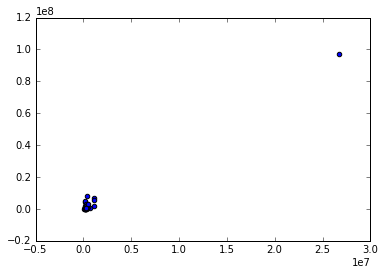

In [26]:
%matplotlib inline
plt.scatter(data_enron["salary"], data_enron["bonus"])

In [27]:
data_enron = data_enron.drop(data_enron["salary"].argmax(), axis=0)

In [28]:
only_numeric = data_enron.loc[:,data_enron.dtypes == "float64"] 

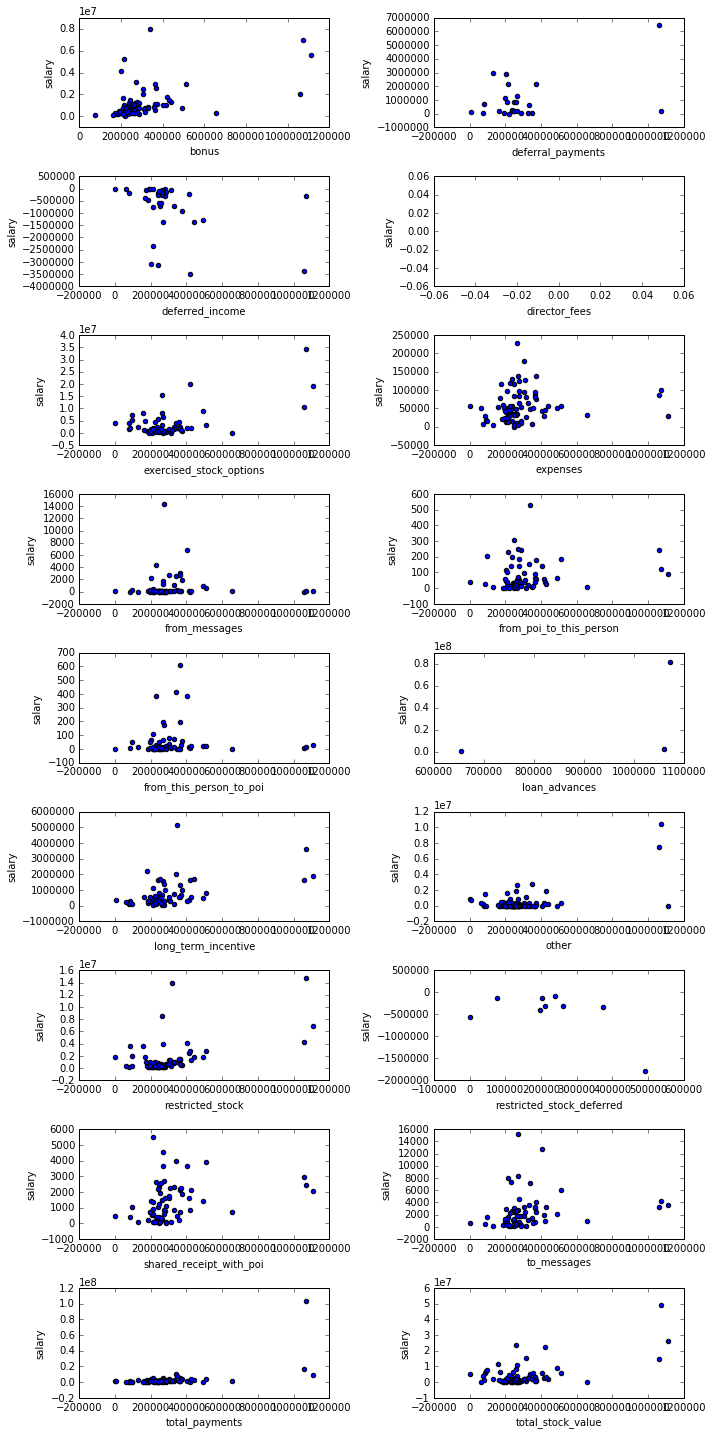

In [29]:
fig, ax = plt.subplots(9, 2, figsize = (10,20))
for number, column in enumerate(only_numeric.columns[only_numeric.columns!= "salary"]):
    ax.flatten()[number].scatter(only_numeric["salary"], only_numeric[column])
    ax.flatten()[number].set_xlabel(column)
    ax.flatten()[number].set_ylabel("salary")
    
plt.tight_layout()

At a first glance, our plots above show us that there are certain variables we should not consider in our analysis because of lack of data. In this category I include the following variables `director_fees`, `loan_advances`, and `restricted_stock_defense`. For the rest, we will follow the proces of fitting our regression, then taking 10% of observations out, and fitting the regresssion again. We also plot the result in order to guide our decisions with a plot inspection.

In [30]:
def outlier_cleaner(pred, y, threshold = 0.9):
    error = ((pred - y)**2).flatten()
    error_lim = np.sort(error)[int(np.rint(len(error)*threshold))]
    no_outl = X[error < error_lim, :]
    outl = X[~(error < error_lim), :]
    y_no_out = y[error < error_lim]
    y_outl = y[~(error < error_lim)]
    return no_outl, y_no_out, outl, y_outl

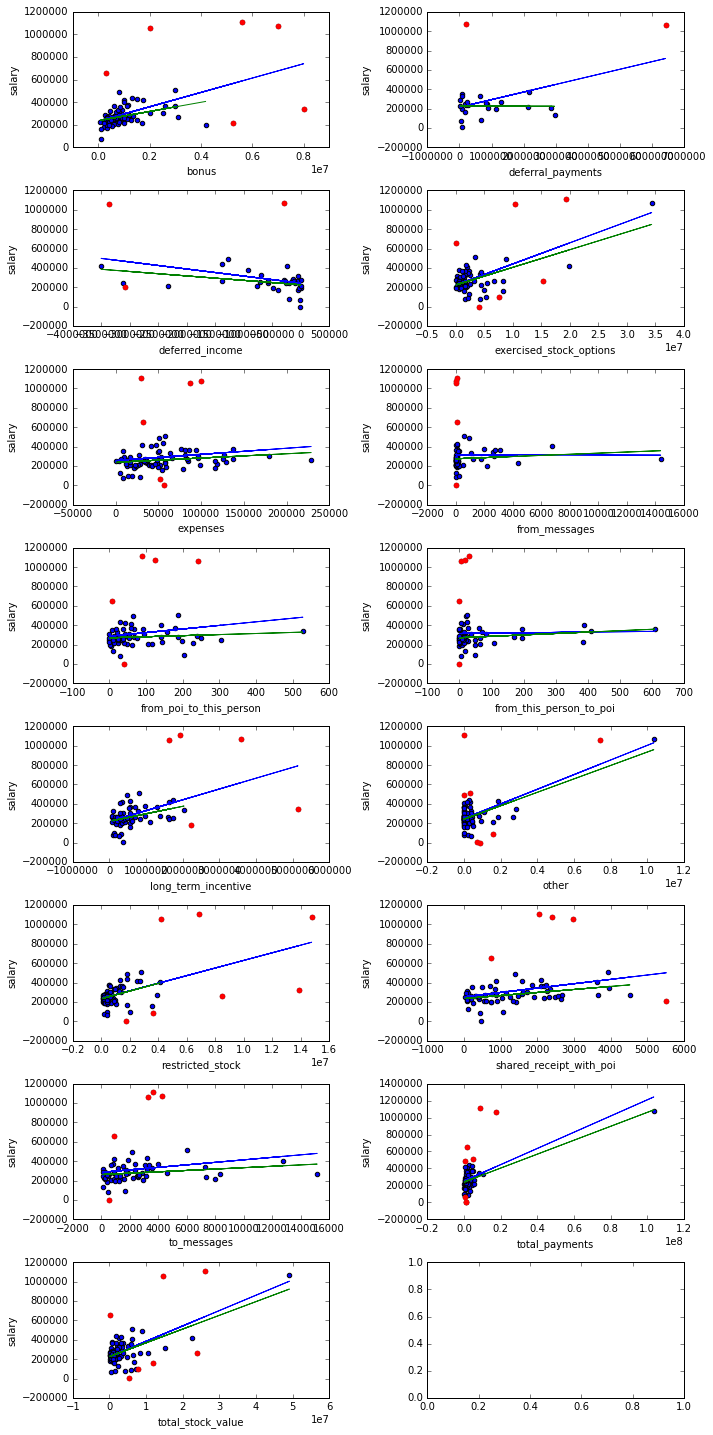

In [31]:
omitted_variables = ["salary", "director_fees","loan_advances", "restricted_stock_deferred"]
fig, ax = plt.subplots(8, 2, figsize = (10,20))
for number, column in enumerate(only_numeric.drop(omitted_variables, axis=1).columns):
    ax.flatten()[number].scatter(only_numeric[column], only_numeric["salary"])
    ax.flatten()[number].set_xlabel(column)
    ax.flatten()[number].set_ylabel("salary")
    reg = linear_model.LinearRegression()
    y, X = dmatrices('salary ~ {}'.format(column), only_numeric)
    reg.fit(X,y)
    pred = reg.predict(X)
    ax.flatten()[number].plot(X[:,1], pred)
    no_outl, y_no_out, outl, y_outl = outlier_cleaner(pred, y, threshold = 0.92)
    ax.flatten()[number].scatter(outl[:,1], y_outl.flatten(), color="red")
    reg.fit(no_outl, y_no_out)
    pred_no_outl = reg.predict(no_outl)
    ax.flatten()[number].plot(no_outl[:,1], pred_no_outl)
plt.tight_layout()

In the graph above we can see some points that has been classified as outliers according to the following method: Firts we fit a regression, then, we calculate the residuals and with these values we only take into account those with residuals errors less than a threshold. In the plots above, we have chosen a 92% residual error. That means we take into account those points who have an error smaller than the 92 percentile of the errors. We plot again the regression lines (in green) too see what is the outlier effect. 

In some regressions we can clearly see the effect of outliers. See for example the effect of the slope in the case of the deferral payments. This is a clear signal of a problematic point if included in our final dataset. There is however a clear problem. The more variables we consider together, the more possibilites of outliers, and the more points we will have to get rid off. Given that we do not have a big data set, we need to be careful when selecting outliers because we might be missing important features in our data. 

In any case, the plots above, give us a good idea of what are the points that we might include/exclude while working with specific variables. 

In [32]:
data_enron.columns

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')

### Identifying other outliers

We also want to validate our points to check if all the data we are going to feed to our algorithms is appropriate. 

As per suggestion, first we will make use of one relevant feature of our data as a way to check if values are correct. In particular, given that we are working with some sort of financial statements, we would have to observe the following:
`'total_payments' = 'salary' + 'bonus' + 'long_term_incentive' + 'deferred_income' + 'deferral_payments' + 'loan_advances' + 'other' + 'expenses' + 'director_fees'`

and 

`'total_stock_value' = 'exercised_stock_options' + 'restricted_stock' + 'restricted_stock_deferred' `


In [81]:
#creating variable for comparison
sum_var = ['salary', 'bonus','long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees']
data_enron["total_pay_comp"] = data_enron.loc[:, sum_var].sum(axis=1)
difference_indicator = data_enron["total_pay_comp"] != data_enron["total_payments"]
#
problem_data = data_enron.loc[difference_indicator, ["total_pay_comp", "total_payments"]][:2].index
data_enron.loc[problem_data, sum_var]

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees
BELFER ROBERT,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN


We notice that there are probles for two entries. We correct them by looking directly at the values of the fincancial statments and proceed with the correct data entry.

In [93]:
data_enron.loc[problem_data[0], ["deferred_income", "deferral_payments", "director_fees", "expenses"]] = [-102500.0, np.nan, 102500.0, 3285]
data_enron.loc[problem_data[1], ["other", "expenses", "director_fees"]] = [np.nan, 137864.0, np.nan]
data_enron["total_pay_comp"] = data_enron.loc[:, sum_var].sum(axis=1)
#correcting problem in total_payments
data_enron.loc[problem_data,"total_payments"] = data_enron.loc[problem_data,"total_pay_comp"]

We will proceed in the same way for the total stock value:

In [98]:
stock_var_sum = ['exercised_stock_options','restricted_stock','restricted_stock_deferred']
data_enron["total_stock_comp"] = data_enron.loc[:, stock_var_sum].sum(axis=1)
difference_indicator_st = data_enron["total_stock_comp"] != data_enron['total_stock_value']
problem_data = data_enron.loc[difference_indicator_st, ["total_stock_comp",'total_stock_value']][:2].index
data_enron.loc[problem_data, stock_var_sum]

,exercised_stock_options,restricted_stock,restricted_stock_deferred
BELFER ROBERT,3285.0,NaN,44093.0
BHATNAGAR SANJAY,2604490.0,-2604490.0,15456290.0


In [104]:
#Correcting wrong entries
data_enron.loc[problem_data[0], stock_var_sum] = [np.nan, -44093.0, 44093.0]
data_enron.loc[problem_data[1], stock_var_sum] = [15456290.0, 2604490.0, -2604490.0]
data_enron["total_stock_comp"] = data_enron.loc[:, stock_var_sum].sum(axis=1)
#Correcting values in original dataset
data_enron.loc[problem_data,'total_stock_value'] = data_enron.loc[problem_data,"total_stock_comp"]

Now we want to check what kind of people do we have in our data set. A basic thing is if everyone is actually people. As we saw before, there was one (TOTAL) that was clearly not a person. Are there other cases?

Note that between the people we have one that is named "THE TRAVEL AGENCY IN THE PARK". We will not remove this observation, because it might give information of a real person that hides under an alias in the statements. On the other hand, checking the financial statements we could see that there was one person with no entries. This person is "Lockhardt, Eugene". We will take it out of our dataset.

In [121]:
data_enron = data_enron.drop("LOCKHART EUGENE E")

## Creating new features

In order to provide our algorithm with better features to distinguish between poi/non poi we thought about creating the following features. We assume that given their special influence in the company, poi had access to confidential and private information from clients or the company. We want to leverage this fact by looking into the mails and checking how many mails sent by a person in Enron contain words like classified, confidential, private, intimate, secret. 

We also assume that poi had access to financial statements or shared financial information about the company. We created, thus, a feature that takes this into account. Our script goes through all of the emails of the people and looks if they contain these key financial words. If an email contains one of these words, we add one to the `num_confidential` for this person. 

In [428]:
FILE_NAME = "data_enron"

In [429]:
content = []
with open("emails_by_address/from_chris.foster@enron.com.txt") as foo:
    for line in foo:
        content.append(line)

In [430]:
complete_mails = data_enron['email_address'].dropna()

In [431]:
def get_mail_sent(mail):
    list_mails_sent = []
    mail_format = "from_"+ mail + ".txt"
    with open("emails_by_address/"+ mail_format) as foo:
        for line in foo:
            list_mails_sent.append(line.strip())
    return list_mails_sent

In [432]:
def get_info_mails(direc_mail_sent):
    path = os.path.join('..', direc_mail_sent.replace("enron_mail_20110402/", ""))
    with open(path, "r") as mail:
        content = parseOutText(mail)
    return content

In [433]:
#attempt classifying all mails that had these words as a stem
def is_important_email(content, pattern):
    return pattern.search(content)

In [434]:
def counting_important_mails(person, mail, pattern):
    num_mails = {person: 0}
    try:
        list_emails = get_mail_sent(mail)
    except IOError:
        return {person: np.nan}
    for mail_sent in get_mail_sent(mail):
        content = get_info_mails(mail_sent)
        if is_important_email(content, pattern):
            num_mails[person] += 1
    return num_mails

In [435]:
private_words = ["classified", "confidential", "intimate", "secret", "privileged"]
#Taking stem of the words
stemmer = SnowballStemmer("english")
private_stem = [stemmer.stem(word) for word in private_words]
pattern = re.compile(r"|\b".join(private_stem), flags=re.IGNORECASE)

In [436]:
#Defining possible financial terms used in mails
financial_terms = ["financial statement", "fraud", "revenue", "report", "income", "tax", "shares"]
financial_stem = [stemmer.stem(word) for word in financial_terms]
finan_pattern = re.compile(r"|\b".join(financial_stem), flags=re.IGNORECASE)

In [437]:
def to_dataframe(dict_list, name_col):
    """Defines helper function to pass
    results to a dataframe."""
    conf_results = {item.keys()[0]: item.values() for item in dict_list}
    new_df = pd.DataFrame(conf_results, index = [name_col]).T
    return new_df

In [135]:
#Getting number of confidential mails
if not os.path.isfile("data_enron"): 
    result_list = []
    financial_mail = []
    for item in range(len(complete_mails)):
        dict_result = counting_important_mails(complete_mails.index[item], complete_mails[item], pattern)
        result_list.append(dict_result)
        dict_result = counting_important_mails(complete_mails.index[item], complete_mails[item], finan_pattern)
        financial_mail.append(dict_result)
    conf_df = to_dataframe(result_list, "num_confidential")
    finan_df = to_dataframe(financial_mail, "num_finantial")
    #Joining it with original dataset
    data_enron = data_enron.join(conf_df, how = "left")
    data_enron = data_enron.join(finan_df, how = "left")

In [136]:
data_enron.columns

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value', u'total_pay_comp',
       u'total_stock_comp'],
      dtype='object')

Another simple feature that we can construct with the information already given is the percentage of mails receive and sent to pois. This will help us determine how close the relationship between this persons were. We would expect that pois would mail more between each other. Therefore, they will have more mails from and sent to pois.

Other thing we want to take into account is the ratio of salary to bonus. One can think that pois have higher bonus, therefore the salaries only constitute a small part of their income. This means that their ratio of salary to bonus will be low. 

In [212]:
#Pct of messages to poi
data_enron["pct_to_poi"] = data_enron.loc[:, 'from_this_person_to_poi'] / data_enron.loc[:, 'to_messages']

#Pct of messagges from poi
data_enron["pct_from_poi"] = data_enron.loc[:, 'from_poi_to_this_person'] / data_enron.loc[:, 'from_messages']

#Ratio salary bonus
data_enron["sal_to_bonus"] = np.log(data_enron.loc[:, 'salary'] / data_enron.loc[:, 'bonus'])

#Ratio salary to total stock value
data_enron["sal_to_stock_value"] = np.log(data_enron.loc[:, 'salary'] / data_enron.loc[:, 'total_stock_value'])

In [213]:
#Storing dataset to a pickle file
data_enron.to_pickle("data_enron")

### Describing Dataset

We read in the data again, with the extra features included, and check some of its characteristics. In particular, we want to check how many data points we have, the total number of features and our missing values.

In [214]:
#Read in pickle stored file
data_enron = pd.DataFrame(pd.read_pickle("data_enron"))

In [215]:
#number of data points
print "Number of observations: {}".format(len(data_enron))
print "Number of features {}".format(len(data_enron.columns))

Number of observations: 144
Number of features 27


As it is possible to see, our dataset is quite small. We only have 145 observations and 23 features. Let's see know how balance are our labels.

In [216]:
print "Number of poi: {}".format(data_enron.poi.sum())

Number of poi: 18


Our dataset is highly unbalance. We only have 18 poi. Given that we do not have that many labels belonging to poi this will dramatically impact on the ability of our algorithms of learning from the data. We will have more robust algorithms if we could feed our algorithms with more data that appropriately describes a poi. 

In [217]:
data_enron.apply(lambda x: x.isnull().sum(), axis=0)

bonus                         71
deferral_payments            107
deferred_income               95
director_fees                129
email_address                 33
exercised_stock_options       51
expenses                      48
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         53
poi                            0
restricted_stock              34
restricted_stock_deferred    127
salary                        58
shared_receipt_with_poi       58
to_messages                   58
total_payments                20
total_stock_value             18
total_pay_comp                18
total_stock_comp              16
pct_to_poi                    58
pct_from_poi                  58
sal_to_bonus                  71
sal_to_stock_value            62
dtype: int64

Another worrying fact is that there are many missing in our dataset. If we only worked with observations for which we have complete cases, chances are that we will have very few points. We tackle this issue in our report. In order not to loose all the information power of the available observations, we perform some kind of imputation. Of course, this imputation may be another source of bias, however we think it is a better solution than working with few or none observation points. 

## Machine learning

Now, we start trying with different machine learning algorithms. For each case, we will select the features we will feed into the algorithm. Additionally, we will adequately split our dataset in training and testing to evaluate the performance of our models and different specifications. 

<span style = "color: #A44242"> 
Throughout we will try to use test.py to perform our testing. testing.py performs a cross-fold validation. This is needed in our case, because we have a pretty small number of samples. Only in the case where test.py takes too long to run, for example when we are exploring svg, we will perform a simple train/test evaluation.
</span>

To start with, we need to determine what kind of task we are doing here. It is clear that we are trying to **classify** these people into two groups: poi/non poi. Therefore, we will be giving extra importance to those algorithms like SVM and Logistic regression that are appropriate for this task. 

We will proceed in the following way. First, we will make clear what features we will use per each algorithm. Then, we will train the model with our training dataset and see what improvements we can make, refit and evaluate again. As this will be a somewhat reiterative process, we will only present some of the steps in the process. In every case, we will be sure to provide enough reasons to justify our decisions. 

During this process, if needed, we will be creating new features and see how does this impact in our algorithms. 

## Choosing features with SelectKBest

SelectKBest can help us in the process of selecting the features that provide a better classification of poi/non poi. We will be using in order to determine which features we will use for our algorithm. 

### Taking out outliers

From the graph above, we can check that there are some outliers that might have a bigger influence in our results that we wanted to. Here, we will take out the outliers for the `salary`, `bonus`, `exercised_stock_options` variable. Then we will proceed to train our model.

We will take those outliers that are in the top right of our plot. This appear to have a significant influence in our regression slopes. Note that for both of this cases, these two outliers are the same, namely the ones that have a higher salary. We will identify them in our dataset and change their values to nan.

In [218]:
#Taking out outliers
index_change = data_enron["salary"].sort_values(ascending = False).index[:2]
#Taking out this variables (setting them to NaN)
data_enron.loc[index_change, ["salary", "bonus", "exercised_stock_options"]] = np.nan

After trying to fit our model, an error because of the use of NaNs was raised. We then, went back and exclude the nans from our dataset. The problem of only considering complete cases, sadly is that we end up with a dataset of 42 observations. In order to preclude this from happening, we impute some values in some of the variables that have the more NaN: num_confidential and num_financial. The NaNs in these cases were cause because there were no mails for these people. We will assume, in this case, that they did not receive any mails with this content. In other words, we will convert the NaNs to zeros.

After doing this, we observe that our dataset is still really sparse (we only have 54 cases). Therefore, we decide to do the following in order not to loose almost half of our data points. To start, we will use some kind of imputation to take this into account. First, we will impute them with 0. As 0 might not be the perfect number to impute, we also consider other form of imputation, namely, the median. We will call this data sets `data_enron_fill_zero`, `data_enron_fill_median`. We will work with both of them to check which one offers better predictions. This way our results are less dependent on the particular form we have selected to fill the nan's.

In [581]:
data_fill_zeros = data_enron.drop(["poi", "email_address"], axis=1).fillna(0)
features_names = data_fill_zeros.columns
data_fill_medians = data_enron.drop(["poi", "email_address"], axis=1).apply(lambda x: x.fillna(x.median()), axis=0)
features_zeros = data_fill_zeros.values
features_medians = data_fill_medians.values
labels = data_enron.poi.values


In [502]:
#Selecting K Best for fill zeros
feature_select = SelectKBest(f_classif, k=7)
feature_fit = feature_select.fit(features_zeros, labels)
print np.sort(feature_fit.scores_)
features_selected = features_names[feature_fit.get_support()]
#selecting features
features_sel_zero = features_zeros[:, feature_fit.get_support()]
features_sel_median = features_medians[:, feature_fit.get_support()]
print features_selected

[  0.1641645    0.22121448   0.74349339   1.07193488   1.32807283
   1.69882435   2.11276199   2.42650813   3.52466845   3.55675118
   4.16908382   4.21988791   5.20965022   5.34494152   5.55068378
   7.2427304    8.74648553   8.96496396   9.15784421   9.3802368
   9.3802368   10.07245453  11.56188771  22.78210783  22.78210783]
Index([u'deferred_income', u'long_term_incentive', u'total_payments',
       u'total_stock_value', u'total_pay_comp', u'total_stock_comp',
       u'sal_to_bonus'],
      dtype='object')


Using our selectKBest and printing the scores, we see that there is a big jump in the score going from 5.5 to 7.24. Selecting 7 as the cutoff gives us 10 features to consider. We perform the same selection for the data set that was filled with  medians. In the end this did not produced a difference as to which features should be selected. 

After having selected these features for both of our datasets, we start splitting our dataset in training and testing. As usual, we wil use our training to fit our algorithm and the testing will be used for evaluation purposes

### Splitting training / testing

In [505]:
features_train_zero, features_test_zero, labels_train_zero, labels_test_zero = train_test_split(features_sel_zero, labels, test_size=0.3, random_state=42)
features_train_median, features_test_median, labels_train_median, labels_test_meadian = train_test_split(features_sel_median, labels, test_size=0.3, random_state=42)

### Naive Bayes

Our benchmark will be a simple naive Bayes. In this case we select the following features: 
- `poi`, which is the label we are trying to predict. 
- `salary`, `bonus`, `exercised stock option`, `num_confidential`, `num_finantial`.

Note that we will use the tester.py to evaluate our results. For this purpose we pass our two datasets to the corresponding form admitted by this function.

In [583]:
data_fill_zeros["poi"] = labels
data_zeros_dict = data_fill_zeros.T.to_dict()
# passing data_fill_zeros
with open('final_data_zeros_proj.pickle', 'wb') as handle:
    pickle.dump(data_zeros_dict, handle)
    
# passing data_median
data_fill_medians["poi"] = labels
data_median_dict = data_fill_medians.T.to_dict()

with open('final_data_medians_proj.pickle', 'wb') as handle:
    pickle.dump(data_median_dict, handle)

In [584]:
#Fittiing Gaussian 
clf = GaussianNB()
clf.fit(features_train_zero, labels_train_zero)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_zeros_dict, features_list, folds = 1000)

GaussianNB(priors=None)
	Accuracy: 0.85633	Precision: 0.44795	Recall: 0.33350	F1: 0.38234	F2: 0.35146
	Total predictions: 15000	True positives:  667	False positives:  822	False negatives: 1333	True negatives: 12178



While our accuracy is good, this is not a very good evaluation metric for our dataset. As we said before, the problem with this dataset is that we have very few observations. On top, we have very few cases to identify poi. Just by choosing the most common label, we would always have a very high accuracy. 

In this case, is more important to see other metrics, like precision and recall. We will give a proper definition later. Note that so far we have obtained a precision of 0.489 and a recall of 0.400.

We will do the same process for our dataset that was filled with the medians. 

In [580]:
clf = GaussianNB()
clf.fit(features_train_median, labels_train_median)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_median_dict, features_list, folds = 1000)

GaussianNB(priors=None)
	Accuracy: 0.85667	Precision: 0.44973	Recall: 0.33550	F1: 0.38431	F2: 0.35346
	Total predictions: 15000	True positives:  671	False positives:  821	False negatives: 1329	True negatives: 12179



Note that our data set that was filled with the medians has a slightly better recall, however the precision gets better in more than one percentage points. This means that, at least for the Naive Bayes, the dataset that was filled with the medians performs better.

### Using SVC

In this section we will use a Support Vector Machine algorithm. Notice, however that in this case we need to rescale our features given that for this algorithm distance in different directions is important. Therefore, we will use a min max scaler as a first step. 

In [451]:
features_sel_zero.shape

(144, 7)

In [459]:
#Scaling features
cv = StratifiedShuffleSplit(n_splits=1000, random_state = 42)
feature_selection = SelectKBest()
scaler = MinMaxScaler()
clf = SVC()
steps = [('feature_selection', feature_select), 
         ("scale", scaler), 
         ('svc', clf)]
pipeline = Pipeline(steps)
parameters = dict(feature_selection__score_func = [f_classif],
                  feature_selection__k= [2, 4, 6, 7, 10, 12, 13, 15, 17, 19, 21, 23],
                 svc__kernel = ["linear", "rbf"],
                 svc__C = [1, 5, 10])
grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring = "f1")
grid.fit(features_zeros, labels)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))



The best parameters are {'feature_selection__k': 23, 'svc__kernel': 'linear', 'feature_selection__score_func': <function f_classif at 0x10d9ae8c0>, 'svc__C': 10} with a score of 0.12


In [460]:
#Scaling features
cv = StratifiedShuffleSplit(n_splits=1000, random_state = 42)
feature_selection = SelectKBest()
scaler = MinMaxScaler()
clf = SVC()
steps = [('feature_selection', feature_select), 
         ("scale", scaler), 
         ('svc', clf)]
pipeline = Pipeline(steps)
parameters = dict(feature_selection__score_func = [f_classif],
                  feature_selection__k= [2, 4, 6, 7, 10, 12, 13, 15, 17, 19, 21, 23],
                 svc__kernel = ["linear", "rbf"],
                 svc__C = [1, 5, 10])
grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring = "f1")
grid.fit(features_medians, labels)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'feature_selection__k': 23, 'svc__kernel': 'linear', 'feature_selection__score_func': <function f_classif at 0x10d9ae8c0>, 'svc__C': 10} with a score of 0.14


In our Support Vector Machine models we have use a pipeline in order to select features and perform the corresponding transformations. We then use a GridSearch. Gridsearch allow us to go through different paremeters specifications, selecting the one that provides better scoring. In order to use the same testing as the one perform by tester.py we have used a Stratified Shuffle split with 1000 folds. 

We have selected as our scoring function the f1, as the one we are looking to maximize. Note that the f1 is a weighted average of the precision and recall scores.

## Using Logit

Logit algorithms can also help us in the process of classification. Logit, additionally assigns a probabity to each of our predictions based on the certainty of the label assigned. This can be useful for selecting different decision thresholds.

We will use the same strategy as before: mainly, we will use a pipeline to perform parameter selection and GridSearch to try different combination of parameters. We will do this for both of our data sets, the ones filled with zeros, and the ones with medians.

In [465]:
feature_selection = SelectKBest()
scaler = MinMaxScaler()
clf = linear_model.LogisticRegression()
steps = [('log_reg', clf)]
pipeline = Pipeline(steps)
parameters = dict(log_reg__penalty = ["l1", "l2"],
                 log_reg__C = [1, 3, 4, 5, 10, 15])
grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring = "recall")
grid.fit(features_zeros, labels)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'log_reg__C': 15, 'log_reg__penalty': 'l1'} with a score of 0.26


In [488]:
cv = StratifiedShuffleSplit(n_splits=1000, random_state = 42)
clf = linear_model.LogisticRegression()
parameters = {"penalty": ("l1", "l2"), "C": [1, 5, 6, 7], "tol": [0.001]}
grid = GridSearchCV(clf, param_grid=parameters, cv=cv, scoring = "precision",)
grid.fit(features_medians, labels)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'penalty': 'l1', 'C': 5, 'tol': 0.001} with a score of 0.29


Still, our algorithm does not take us quite there were we wanted. Our recall does not hit the more than 30% mark, as wanted. Therefore, we will try with other algorithms. Note that we tried for the second with scaling options, but it yielded a lower score than using no scaling at all. 


### Using Decision Trees

We will use now decision trees in order to classify the labels correctly. Something to take into account when using trees is their tendency to overfit. We will try to combat this using the tuning parameters appropriately. 

In [489]:
cv = StratifiedShuffleSplit(n_splits=1000, random_state = 42)
scaler = MinMaxScaler()
clf = tree.DecisionTreeClassifier()
steps = [('feature_selection', feature_select), 
         ('my_tree', clf)]
pipeline = Pipeline(steps)
parameters = dict(feature_selection__score_func = [f_classif],
                  feature_selection__k= [2, 4, 6, 7, 10, 12, 13, 15, 17, 19, 21, 23],
                 my_tree__min_samples_split = [2, 3, 4, 7, 10, 12, 13, 14, 15])
grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring = "f1")
grid.fit(features_zeros, labels)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'feature_selection__k': 2, 'feature_selection__score_func': <function f_classif at 0x10d9ae8c0>, 'my_tree__min_samples_split': 15} with a score of 0.21


Our first results, without tuning are surprisingly good. While our accuracy is not the best, our precision and recall are very weak. In no case we get to single out correctly a person that belongs to the poi class.

In [498]:
cv = StratifiedShuffleSplit(n_splits=1000, random_state = 42)
clf = tree.DecisionTreeClassifier()
steps = [('feature_selection', feature_select), 
         ('my_tree', clf)]
pipeline = Pipeline(steps)
parameters = dict(feature_selection__score_func = [f_classif],
                  feature_selection__k= [2],
                 my_tree__min_samples_split = [14, 15, 20, 25, 30, 50])
grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring = "recall")
grid.fit(features_medians, labels)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'feature_selection__k': 2, 'feature_selection__score_func': <function f_classif at 0x10d9ae8c0>, 'my_tree__min_samples_split': 20} with a score of 0.19


In [551]:
clf = tree.DecisionTreeClassifier(min_samples_split = 5)
clf.fit(features_train_zero, labels_train_zero)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_zeros_dict, features_list, folds = 1000)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.82040	Precision: 0.27141	Recall: 0.20600	F1: 0.23422	F2: 0.21643
	Total predictions: 15000	True positives:  412	False positives: 1106	False negatives: 1588	True negatives: 11894



In [562]:
clf = tree.DecisionTreeClassifier(min_samples_split = 4)
clf.fit(features_train_median, labels_train_median)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_median_dict, features_list, folds = 1000)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.79660	Precision: 0.22063	Recall: 0.20750	F1: 0.21386	F2: 0.21000
	Total predictions: 15000	True positives:  415	False positives: 1466	False negatives: 1585	True negatives: 11534



Once again, our algorithm performs lower than we wanted to. We will try to get better scores using an Ada Boost Tree that prevents overfitting.

### Using Ada Boost

We will use another form of classification. This time we will use Ada Boost, which corrects for overfitting that is sometimes present in Decision Trees.

For this case, we will use the first features that we selected for our Naive Bayes classification. 


In [563]:
clf = AdaBoostClassifier(n_estimators=75)
clf.fit(features_train_zero, labels_train_zero)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_zeros_dict, features_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=75, random_state=None)
	Accuracy: 0.81913	Precision: 0.21995	Recall: 0.14000	F1: 0.17110	F2: 0.15098
	Total predictions: 15000	True positives:  280	False positives:  993	False negatives: 1720	True negatives: 12007



In [507]:
clf = AdaBoostClassifier()
clf.fit(features_train_median, labels_train_median)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_median_dict, features_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.80960	Precision: 0.21618	Recall: 0.16300	F1: 0.18586	F2: 0.17143
	Total predictions: 15000	True positives:  326	False positives: 1182	False negatives: 1674	True negatives: 11818



## Using Random Forest

As a last resource, we will use random forest to see if we can get better results so far. Till now, we have not being able to beat the result we had with naive Bayes. Again, random forests prevents from some of the overfitting problems that occur with decision trees.

In [575]:
clf = RandomForestClassifier(min_samples_split = 20)
clf.fit(features_train_zero, labels_train_zero)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_zeros_dict, features_list, folds = 1000)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85973	Precision: 0.41975	Recall: 0.13600	F1: 0.20544	F2: 0.15726
	Total predictions: 15000	True positives:  272	False positives:  376	False negatives: 1728	True negatives: 12624



In [578]:
clf = RandomForestClassifier(min_samples_split = 5)
clf.fit(features_train_median, labels_train_median)
features_list = ["poi"] + list(features_selected)
test_classifier(clf, data_median_dict, features_list, folds = 1000)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85047	Precision: 0.36750	Recall: 0.16850	F1: 0.23106	F2: 0.18896
	Total predictions: 15000	True positives:  337	False positives:  580	False negatives: 1663	True negatives: 12420



In the end, using Random Forest didn't make much of a difference in terms of getting better precision or recall.

## Questionnaire - Conclusions

Having gone through multiple algorithms, their pros - cons and tunned their parameters, we can select the algorithm that better performed on our data. Ironically, our best performing algorithm is one of the simplest ones: the Naive Bayes. 

1. As we mentioned in the introduction machine learning offers the ability of learning from patterns in the data in order to give informed predictions. We have worked here with the Enron data set. This data set contained financial information about the company and other information obtained through a series of mails that the justice made available to the public. The Enron case is one of the most known corporate fraud cases. Knowing the patterns of the fraud can help us predict it in the future. In our case, however, the predictive task was simpler. We were given a list of persons that were connected to Enron, and we wanted to determine if these persons could be catalogued as a person of interest. We used the futures in our dataset to perform classifications. During this process we were careful not to use all of the data points, given that some of them could introduce some unwanted bias.

2. We used the features identified by our SelectKBest algorithm. In the end, we selected 7 features that have the highest scores. These features are: 'deferred_income', 'long_term_incentive', 'total_payments', 'total_stock_value', 'total_pay_comp', 'total_stock_comp','sal_to_bonus'. We also perform some scaling in the cases where it was needed. In particular, we used the min/max scaling. Scaling is particular important with algorithms like SVM and KMeans given that they essentially are taking the distance in all of the relevant dimensions into account. Note that we also engineered two features processing the mails given. We also engineered some extra features with the data given. For example, the proportion of mails received from poi and sent to the poi. Another thing we wanted to take into consideration was the difference between salaries to bonus and salaries to total stocks. The reason behind this was that most of pois income may come from these extra perks and not salary. We use a logarithmic scale, because this had a better score when selecting features.

As seen above, we choose 7 because it gave us good precision/recall values with the algorithms selected. Note, however, that througout our code, we also try with different values of K. In particular we do this for SVM, Logit, Decision Trees. In all of the cases we also tuned different parameters. However, in the end, we do not get better results than with our naive Bayes.

3. As it is possible to see throughout this report, we considered multiple algorithms and tune their parameters. We also compared between our algorithms using different evaluation metrics, as accuracy, precision and recall. In the end we choose the algorithm that offers the best precision and recall scores. We do this for two of our datasets, the one where we imputed the blank values with zero and the ones with medians. In both cases we get a precision of over 44% and a recall of over 33%. 

4. Tunning the parameters of the algorithm means changing some of its specifications. Tunning is important because it help us in the quest of finding an appropriate balance between bias and variance. In our case, where appropriate, we have tunned different parameters of our algorithms. For example, we have used different imputation methods for our dataset. Also in cases where needed, we tuned our parameters using GridSearchCV. For example, for SVM we used different kernels and different values of C to control for overfitting. However, our work was not fruitful, tunning the parameters did not yield better performance that the one obtained with our naive Bayes. 

5. Validation is the technique of separating your dataset for analyzing the performance of your algorithm. In general, we want our algorithm to reduce the sources of errors as maximum as possible to give us good predictions. A method of trying to assess how much error we have in our predicitions is to separate our dataset in training and testing. We fit our algorithm with the data of the training set and then check the performance of our algorithm against the testing set. If this procedure is not followed, multiple problems may arise. One of the most significant ones, is that we might be prone to overfitting. If we use the same data for fitting and evaluation purposes in the end we will prefer those models that fit perfectly to the data at hand. This model will prove to be a poor generalization for the rest of the data, and therefore will generate poor predictions. In our analysis we were carefult to always separate our data in training and testing. The fitting was done with the training data, the evaluation with the testing data. 

6. As we explained above, we use three different performance metrics: accuracy, precision and recall. As we have quite an inbalance dataset (we have very few poi cases), we can get a high accuracy just by guessing that a person is not poi. Therefore, we wanted to concentrate on precision and recall.

Suppose, for example, that each person that might be identified as a potential poi will be further screened. This will imply high cost for the administration and for the person if they are incorrectly labeled like that. On the other hand, in terms of justice, we want to make sure that all of the persons that had been involved in this scandal will be prosecuted. Depending on which costs we want to minimize we might be looking at precision or recall. In those cases we might be more interested in using measures like precision / recall.

**Precision**, refers to the ability of our algorithm to identify persons that are truly persons of interest. A good precision means that everytime someone is labeled as a poi by our algorithm, we have high confidence that that person is in fact a poi.

**Recall** refers to the ability of our algorithm to identify all of those poi in our dataset. A good recall gives us the confidence that if we have a poi in our dataset, it will not be ignored by our algorithm.

Unfortunately, precision and recall sometimes do not go hand in hand. To see this, consider an example where our algorithm labels all as poi. The recall will be perfect. All of the poi in our dataset were correctly identified. On the other hand, the precision is terrible, given that this algorithm does not give us the confidence that someone labeled as poi is actually such. On the other hand we might have an algorithm that is very precise: once someone is taken to be a poi we are very confident that it is actually is. However, this confidence might come at a cost of not being able to identify all of the actual poi in our dataset, rendering our recall low.